In [1]:
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from copy import deepcopy

from collections import Counter
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from kmeans_smote import KMeansSMOTE
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from bayes_opt import BayesianOptimization

In [2]:
sns.set()
%matplotlib inline
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

# Data loading

In [3]:
%%time
df_input_data = pd.read_csv('data_for_test.csv')

Wall time: 20.3 s


In [4]:
df_input_data.head(3)

,Unnamed: 0,volatility_atr,volume_adi,momentum_tsi,momentum_rsi,momentum_stoch,momentum_wr,returns_lag_1,minute,"value__fft_coefficient__coeff_0__attr_""abs""",...,"value__fft_coefficient__coeff_2__attr_""angle""","value__fft_coefficient__coeff_8__attr_""abs""",value__number_crossing_m__m_0,value__c3__lag_2,"value__fft_aggregated__aggtype_""variance""",returns_25,returns_16,returns_26,datetime,target
0,1029308,4.755788,3.628946,-10.529437,37.194389,46.031746,-53.968254,-0.000534,28,0.000738,...,-176.665127,0.000189,40.0,2.667893e-14,202.579849,-0.001333,-0.001245,-0.000934,2019-07-03 02:28:07.451296,2
1,1029309,4.916089,11.879556,-11.035900,32.105300,33.870968,-66.129032,0.000668,28,0.000642,...,-169.138277,0.000142,41.0,2.990430e-14,193.880508,-0.001822,-0.001156,-0.001689,2019-07-03 02:28:12.417695,1
2,1029310,4.993511,-84.111236,-11.638534,29.221935,25.806452,-74.193548,-0.000356,28,0.000614,...,-161.615718,0.000124,42.0,2.034959e-14,193.772288,-0.002000,-0.001867,-0.002044,2019-07-03 02:28:16.904005,1


In [5]:
df_part_1 = df_input_data.iloc[0:205855]
#df_part_2 = df_input_data.iloc[205855:411710]
#df_part_3 = df_input_data.iloc[411710:617565]
#df_part_4 = df_input_data.iloc[617565:823420]
#df_part_5 = df_input_data.iloc[823420:1029275]

In [6]:
df_part_1.head()

,Unnamed: 0,volatility_atr,volume_adi,momentum_tsi,momentum_rsi,momentum_stoch,momentum_wr,returns_lag_1,minute,"value__fft_coefficient__coeff_0__attr_""abs""",...,"value__fft_coefficient__coeff_2__attr_""angle""","value__fft_coefficient__coeff_8__attr_""abs""",value__number_crossing_m__m_0,value__c3__lag_2,"value__fft_aggregated__aggtype_""variance""",returns_25,returns_16,returns_26,datetime,target
0,1029308,4.755788,3.628946,-10.529437,37.194389,46.031746,-53.968254,-0.000534,28,0.000738,...,-176.665127,0.000189,40.0,2.667893e-14,202.579849,-0.001333,-0.001245,-0.000934,2019-07-03 02:28:07.451296,2
1,1029309,4.916089,11.879556,-11.035900,32.105300,33.870968,-66.129032,0.000668,28,0.000642,...,-169.138277,0.000142,41.0,2.990430e-14,193.880508,-0.001822,-0.001156,-0.001689,2019-07-03 02:28:12.417695,1
2,1029310,4.993511,-84.111236,-11.638534,29.221935,25.806452,-74.193548,-0.000356,28,0.000614,...,-161.615718,0.000124,42.0,2.034959e-14,193.772288,-0.002000,-0.001867,-0.002044,2019-07-03 02:28:16.904005,1
3,1029311,5.208260,-25.581478,-11.595321,46.847541,51.612903,-48.387097,-0.000223,28,0.000557,...,-153.262794,0.000079,42.0,2.739726e-14,192.809492,-0.001244,-0.001289,-0.001289,2019-07-03 02:28:19.511842,1
4,1029312,5.336242,76.739954,-11.080417,56.907916,72.580645,-27.419355,0.000713,28,0.000424,...,-141.615027,0.000064,43.0,2.976626e-14,202.027115,-0.000133,-0.000755,-0.000667,2019-07-03 02:28:25.252526,1


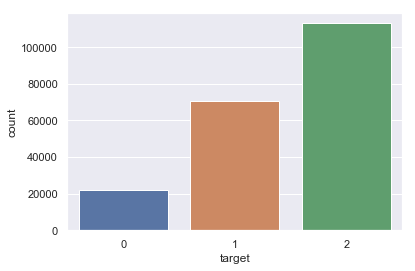

In [7]:
sns.countplot(df_part_1['target'])

In [8]:
print(sum(df_part_1['target'] == 0))
print(sum(df_part_1['target'] == 1))
print(sum(df_part_1['target'] == 2))

21915
70771
113169


# Bayesian Optimization

In [9]:
def lgb_eval(max_depth, 
             num_leaves,
             reg_alpha,
             reg_lambda):
    
    params = {'objective':'multiclass',
              'num_class': 3,
              'num_iterations':4000, 
              'learning_rate':0.05, 
              'early_stopping_round':100, 
              'metric':'multi_logloss'}
    
    params['max_depth'] = round(max_depth)
    params['num_leaves'] = round(num_leaves)
    params['reg_alpha'] = max(reg_alpha, 0)
    params['reg_lambda'] = max(reg_lambda, 0)
    
    cv_result = lgb.cv(params, 
                       train_data, 
                       nfold=n_folds, 
                       seed=random_seed, 
                       stratified=True, 
                       verbose_eval =200, 
                       metrics=['multi_logloss'])
    
    return min(cv_result['multi_logloss-mean'])

In [10]:
lgbBO = BayesianOptimization(lgb_eval, {'max_depth': (5, 8.99),
                                        'num_leaves': (24, 45),                                        
                                        'reg_alpha': (0, 5),
                                        'reg_lambda': (0, 3)}, 
                             random_state=0)

In [11]:
def bayes_parameter_opt_lgb(X, 
                            y, 
                            init_round=15, 
                            opt_round=25, 
                            n_folds=5, 
                            random_seed=6, 
                            n_estimators=10000, 
                            learning_rate=0.05, 
                            output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, 
                             label=y, 
                             free_raw_data=False)
    # parameters
    
    def lgb_eval(max_depth,
                 num_leaves,
                 reg_alpha,
                 reg_lambda):
        
        params = {'objective':'multiclass',
                  'num_class': 3,
                  'num_iterations': n_estimators, 
                  'learning_rate':learning_rate, 
                  'early_stopping_round':100, 
                  'metric':'multi_logloss'}
        
        params['max_depth'] = int(round(max_depth))
        params['num_leaves'] = int(round(num_leaves))
        params['reg_alpha'] = max(reg_alpha, 0)
        params['reg_lambda'] = max(reg_lambda, 0)
        
        cv_result = lgb.cv(params, 
                           train_data, 
                           nfold=n_folds, 
                           seed=random_seed,
                           stratified=True, 
                           verbose_eval =200, 
                           metrics=['multi_logloss'])
        return min(cv_result['multi_logloss-mean'])
    
    # range
    
    lgbBO = BayesianOptimization(lgb_eval, {'max_depth': (5, 8.99),
                                            'num_leaves': (24, 45),
                                            'reg_alpha': (0, 5),
                                            'reg_lambda': (0, 3)}, 
                             random_state=0)
    
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return best parameters
    return lgbBO
#lgbBO.res['max']['max_params']

# Standard boost for 3 classes

In [12]:
data_train = df_part_1.iloc[0:164684]
data_test = df_part_1.iloc[164684:]
X = data_train.drop(['target', 'datetime'], axis=1)
y = data_train['target']

In [13]:
X_test = data_test.drop(['target', 'datetime'], axis=1)
y_test = data_test['target']

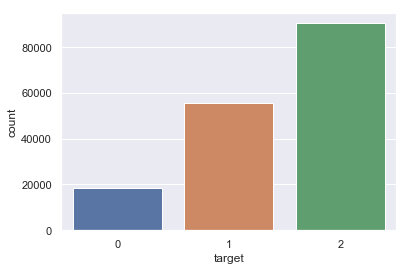

In [14]:
sns.countplot(y)

# Sampling

### Oversampling SMOTE (Kmeans)

In [15]:
kmeans_smote = KMeansSMOTE(kmeans_args={'n_clusters': 100},
                           smote_args={'k_neighbors': 10})

In [16]:
#sm = SMOTE(random_state=42)
#X_res_0, y_res_0 = sm.fit_resample(X, y)

### Undersampling Tomek Links

In [17]:
#tomek_links = TomekLinks(return_indices=True, ratio='majority')
#X_tl, y_tl, id_tl = tl.fit_sample(X, y)

In [18]:
%%time
X_resampled, y_resampled = kmeans_smote.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_resampled))

Resampled dataset shape Counter({0: 162303, 1: 125333, 2: 90464})
Wall time: 17.3 s


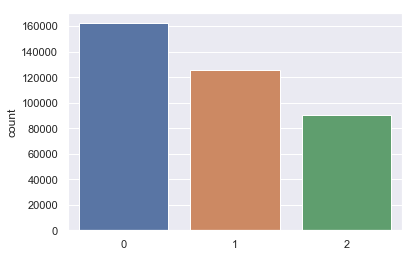

In [19]:
sns.countplot(y_resampled)

# Selection of classifier parameters

In [20]:
opt_params = bayes_parameter_opt_lgb(X_resampled, 
                                     y_resampled, 
                                     init_round=5, 
                                     opt_round=10, 
                                     n_folds=3, 
                                     random_seed=6, 
                                     n_estimators=100, 
                                     learning_rate=0.05)

|   iter    |  target   | max_depth | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------
|  1        |  0.7889   |  7.19     |  39.02    |  3.014    |  1.635    |
|  2        |  0.7895   |  6.69     |  37.56    |  2.188    |  2.675    |
|  3        |  0.7837   |  8.845    |  32.05    |  3.959    |  1.587    |
|  4        |  0.7838   |  7.266    |  43.44    |  0.3552   |  0.2614   |
|  5        |  0.8284   |  5.081    |  41.49    |  3.891    |  2.61     |
|  6        |  0.8317   |  5.0      |  24.0     |  5.0      |  0.0      |
|  7        |  0.7679   |  8.861    |  44.86    |  4.719    |  2.82     |
|  8        |  0.8289   |  5.029    |  45.0     |  4.81     |  0.0      |
|  9        |  0.8324   |  5.092    |  24.03    |  4.807    |  2.822    |
|  10       |  0.8285   |  5.124    |  31.01    |  4.998    |  2.787    |
|  11       |  0.8276   |  5.0      |  45.0     |  5.134e-0 |  3.0      |
|  12       |  0.8283   |  5.0      | 

In [21]:
opt_params.max['params']

{'max_depth': 5.0921188048863755,
 'num_leaves': 24.030408156061032,
 'reg_alpha': 4.80734030451425,
 'reg_lambda': 2.821752599850759}

In [57]:
model_params = {'max_depth': int(opt_params.max['params']['max_depth']),
                'num_leaves': int(opt_params.max['params']['num_leaves']),
                'boosting_type': 'gbdt',
                'reg_alpha': opt_params.max['params']['reg_alpha'],
                'reg_lambda': opt_params.max['params']['reg_lambda']
               }
                            
optim_params = {'num_boost_round': 200,
                'num_iterations':4000,
                'learning_rate':0.05
               }

task_params = {'objective':'multiclass',
               'num_class': 3,
               'metric':'multi_logloss'
              }
    
device_params = {'device': 'cpu',
                 'num_threads': 4
                }

In [58]:
total_dict = dict(**model_params, **task_params, **device_params, **optim_params)

In [59]:
%%time
clf = LGBMClassifier(**total_dict)

Wall time: 0 ns


In [60]:
%%time
clf.fit(X_resampled, y_resampled)

Wall time: 16min 50s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        device='cpu', importance_type='split', learning_rate=0.05,
        max_depth=5, metric='multi_logloss', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_boost_round=200, num_class=3, num_iterations=4000,
        num_leaves=24, num_threads=4, objective='multiclass',
        random_state=None, reg_alpha=4.9152473213595025,
        reg_lambda=2.761238728782681, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [40]:
%%time
y_pred = clf.predict(X_test)

Wall time: 2min 8s


In [46]:
print(f1_score(y_test, y_pred, average='micro'))

0.4727545650195019


In [64]:
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.simplefilter('ignore')
clf_1 = RandomForestClassifier(random_state=0)
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf, clf_1], 
                          meta_classifier=lr)

print('3-fold cross validation:\n')

for clf, label in zip([clf, clf_1, sclf], 
                      ['0', 
                       '1', 
                       '2',
                       'StackingClassifier']):

    scores = cross_val_score(clf, X_resampled, y_resampled, 
                                              cv=3, scoring='f1')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:



ValueError: Target is multiclass but average='binary'. Please choose another average setting.

In [52]:
print(f1_score(y_test, y_pred, average='weighted'))

0.4416098256642884
